In [ ]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# add path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.utils import train_and_evaluate
warnings.filterwarnings("ignore")

In [3]:
file_path = "../data/processed/ecommerce_customer_data_cleaned.csv"
df = pd.read_csv(file_path)
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"])

## Business Questions (transaction level)

### Question 1: Are there relationships between 'Payment Method', 'Gender' respect to 'Total Purchase Amount'?
- The plot and t-test suggest that customers using credit cards tend to spend differently compared to those using cash or PayPal.
- However, considering the fees of credit card transactions, it might not be more profitable even if the average purchase amount is higher.
- Next step:
    - to see if the payment methods are related to demographic factors.
    - to see if the churn rate and return rate are associated with payment method.

In [4]:
group1 = df[df['Gender'] == 'Male']['Total Purchase Amount']
group2 = df[df['Gender'] == 'Female']['Total Purchase Amount']
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# The p-value is greater than 0.05, indicating no significant difference in total purchase amounts between

T-statistic: 0.7523686291333156, P-value: 0.4518301151276066


Payment Method
Credit Card    2738.852562
PayPal         2721.677952
Cash           2715.557437
Name: Total Purchase Amount, dtype: float64
  Payment Method 1 Payment Method 2  t-statistic   p-value
0           PayPal      Credit Card    -2.432306  0.015004
1           PayPal             Cash     0.865958  0.386515
2      Credit Card             Cash     3.293935  0.000988


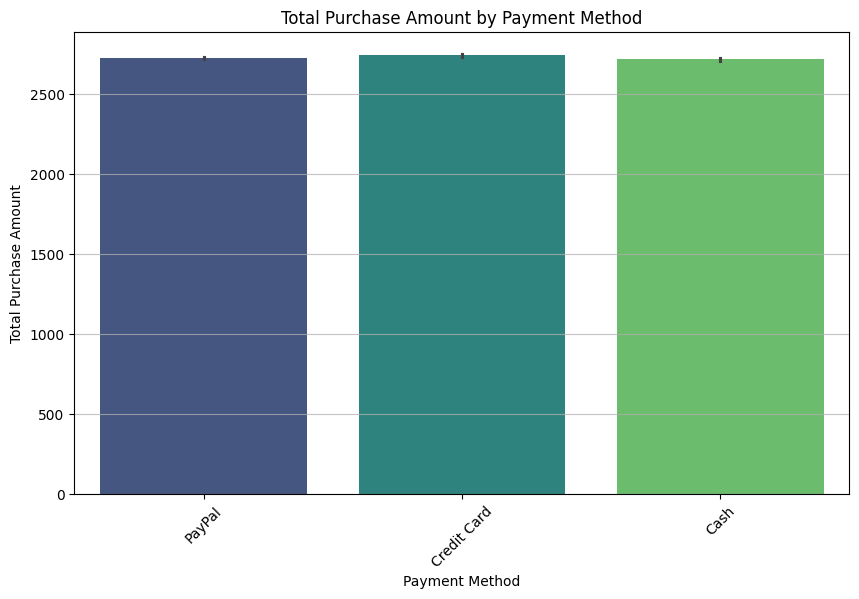

In [ ]:
# Is there a relationship between 'Payment Method' and 'Total Purchase Amount'?
print("Average Total Purchase Amount by Payment Method:")
print(df.groupby("Payment Method")["Total Purchase Amount"].mean().sort_values(ascending=False))

# The difference of total purchase amount by payment method is not obvious by the bar plot.
# Run a t-test to see if there is a significant difference
payment_methods = df['Payment Method'].unique()
# Perform t-tests between pairs of payment methods
results = []
for i in range(len(payment_methods)):
    for j in range(i + 1, len(payment_methods)):
        method1 = payment_methods[i]
        method2 = payment_methods[j]
        group1 = df[df['Payment Method'] == method1]['Total Purchase Amount']
        group2 = df[df['Payment Method'] == method2]['Total Purchase Amount']
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        results.append((method1, method2, t_stat, p_value))
# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=['Payment Method 1', 'Payment Method 2', 't-statistic', 'p-value'])
print(results_df)

# Visualize the total purchase amount by payment method
plt.figure(figsize=(10, 6))
sns.barplot(x='Payment Method', y='Total Purchase Amount', data=df, estimator=np.mean, palette='viridis', hue='Payment Method')
plt.title('Total Purchase Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

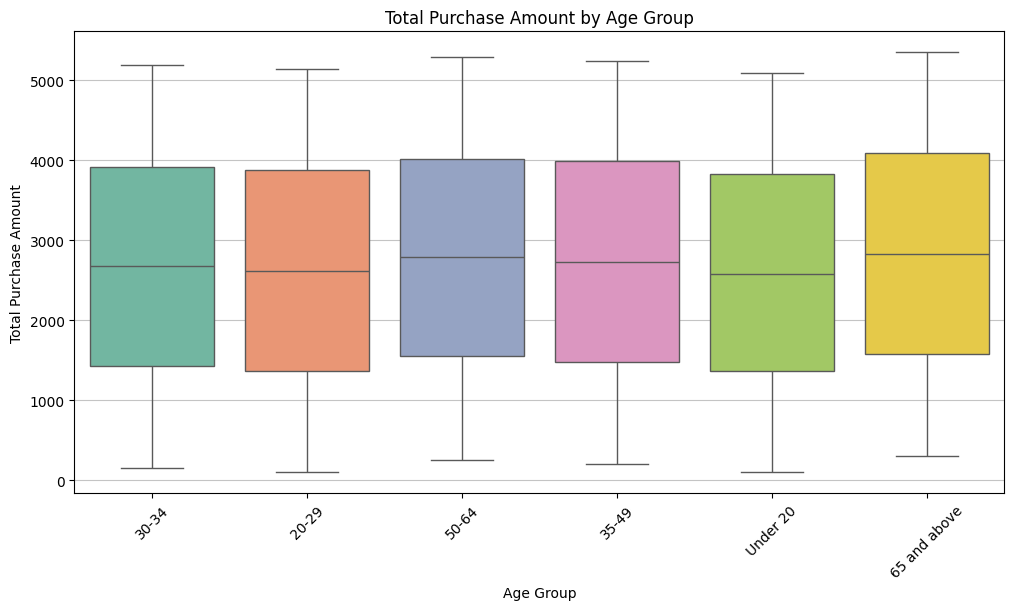

In [6]:
# create a new variable for age groups to seperate the age distribution
def age_group(age):
    if age < 20:
        return 'Under 20'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-34'
    elif 40 <= age < 50:
        return '35-49'
    elif 50 <= age < 60:
        return '50-64'
    else:
        return '65 and above'
df['Age Group'] = df['Age'].apply(age_group)
# Visualize the distribution of total purchase amount by age group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Group', y='Total Purchase Amount', data=df, palette='Set2')
plt.title('Total Purchase Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

### Question 2: Does the data exist seasonality?
- the total purchase amount
- revenue gained by category

<Axes: xlabel='Purchase Month', ylabel='Total Purchase Amount'>

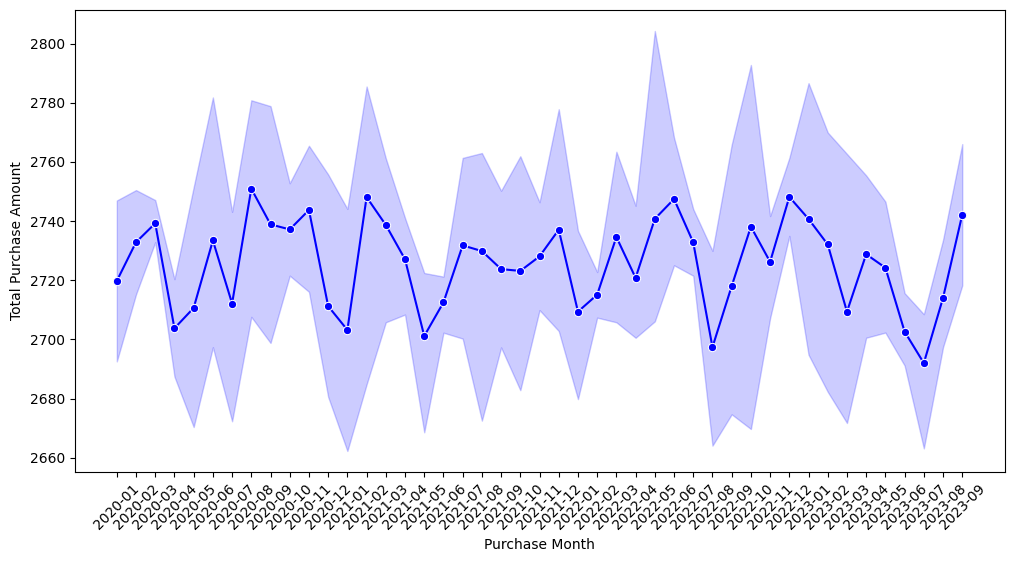

In [ ]:
### Question: Does the total purchase amount by each category exist seasonality?
# Extract month from 'Purchase Date' for seasonality analysis
# truncate the date to month as "YYYY-MM"
df['Purchase Month'] = df['Purchase Date'].dt.to_period('M').astype(str)
# Group by month and calculate the average total purchase amount
monthly_totals = df.groupby(['Purchase Month', 'Product Category'])['Total Purchase Amount'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
sns.lineplot(x='Purchase Month', y='Total Purchase Amount', data=monthly_totals, marker='o', color='blue')

In [11]:
# testify if there is seasonality
# Perform ANOVA to test for differences in means across months
anova_results = stats.f_oneway(*[group['Total Purchase Amount'].values for name, group in monthly_totals.groupby('Purchase Month')])
print(f"ANOVA F-statistic: {anova_results.statistic}, P-value: {anova_results.pvalue}")
if anova_results.pvalue < 0.05:
    print("There is a significant difference in total purchase amounts across months, indicating seasonality.")
else:
    print("No significant difference in total purchase amounts across months, indicating no seasonality.")

ANOVA F-statistic: 0.6167853606771777, P-value: 0.9669183587213135
No significant difference in total purchase amounts across months, indicating no seasonality.


### Question 3: Can the returns be predicted based on the other features?
- [X] logistic regression
- [X] xgboost
- [X] lightgbm
- [X] random forest
- after trying all the models, it is shown that these models are not able to predict the returns accurately, as the AuC is around 0.5, which is no better than random guessing.
    - The features in the dataset may not be able to provide sufficient information to predict returns effectively.
    - The returns may be influenced by factors not captured in the dataset, such as customer behavior, product quality, or external market conditions.

In [13]:
fila_path = "../data/processed/ecommerce_customer_data_large_numeric.csv"
df_numeric = pd.read_csv(fila_path)

In [14]:
X = df_numeric.drop(columns=['Returns'])
y = df_numeric['Returns']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# create a dictionary to map model names to the model objects
model_dict = {
    "logistic": LogisticRegression(max_iter=1000),
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "random_forest": RandomForestClassifier(),
    "lightgbm": LGBMClassifier()
}

results = []
# Iterate through the model dictionary and train each model
for model_name, model in model_dict.items():
    # Train and evaluate the model
    result_dict = train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name)
    results.append(result_dict)
results_df = pd.DataFrame(results)
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 81223, number of negative: 118777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.406115 -> initscore=-0.380049
[LightGBM] [Info] Start training from score -0.380049


,model,accuracy,precision,recall,f1_score,auc
0,logistic,0.59494,0.000000,0.000000,0.000000,0.505574
1,xgboost,0.58730,0.405726,0.040587,0.073791,0.497118
2,random_forest,0.55028,0.405405,0.236261,0.298540,0.497306
3,lightgbm,0.59438,0.416667,0.003456,0.006856,0.497912
